In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.11.0


In [2]:
# IMDB 数据集进行了预处理，将影评（字词序列）转换为整数序列，其中每个整数表示字典中的一个特定字词。
imdb = keras.datasets.imdb
# 只将数据集中频次超过10000的单词存入训练集和验证集中
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17473536/17464789 [==============================] - 38s 2us/step


In [3]:
# 2.探索数据，了解数据格式
# 探索训练数据集，训练数据个数与标签数
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [4]:
# 数据组成（整数？字符？浮点数？）
# 每个样本都是一个整数数组，表示影评中的字词。每个标签都是整数值 0 或 1，其中 0 表示负面影评，1 表示正面影评。
# 影评文本已转换为整数，其中每个整数都表示字典中的一个特定字词
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [5]:
len(train_data[0]), len(train_data[1])

(218, 189)

In [6]:
# 3.数据预处理，将数字转化为单词，统一数字大小格式
# word_index is a dictionary mapping words to an integer index
# word_index是一个字典，将单词映射为整数，函数get_word_index()获取词索引并赋予word_index
word_index = imdb.get_word_index()


# The first indices are reserved
# k是单词，v是数字，由于字符：空，开始，未知，UNUSED已被映射为数字0-3,所以数字要加三；
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3
# word_index中单词为键，数字为值，在reverse_word_index中反转为数字为键，单词为值
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# 函数decode_review根据数字输出单词，i表示数字
# join加入单词，用空格分隔单词
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1654784/1641221 [==============================] - 4s 3us/step


In [7]:
decode_review(train_data[0])

u"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for w

In [8]:
# 影评（整数数组）必须转换为张量，然后才能馈送到神经网络中

# pad_sequences()将多个序列截断或补齐为相同长度。
# 该函数将一个 num_samples 的序列（整数列表）转化为一个 2D Numpy 矩阵，其尺寸为 (num_samples, num_timesteps)。 num_timesteps 要么是给定的 maxlen 参数，要么是最长序列的长度。
# 比 num_timesteps 短的序列将在末端以 value 值补齐。
# 比 num_timesteps 长的序列将会被截断以满足所需要的长度。补齐或截断发生的位置分别由参数 pading 和 truncating 决定。
# 向前补齐为默认操作。

# 本例中补齐填充值为0，value=word_index["<PAD>"]，补齐方式为向后补齐，padding='post'，数组长度统一为256，maxlen=256。
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [9]:
len(train_data[0]), len(train_data[1])

(256, 256)

In [10]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

In [11]:
# 4.构建模型，设置模型的层个数，类型等
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000 #取输入集中的1000个单词进行训练

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16)) #嵌入层，将数字转换为向量，使用word2vec模型中的skip-gram模型，用16维表示一个向量
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [14]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 82us/step - loss: 0.6924 - acc: 0.5108 - val_loss: 0.6913 - val_acc: 0.5169
Epoch 2/40
15000/15000 [==============================] - 1s 51us/step - loss: 0.6886 - acc: 0.5641 - val_loss: 0.6857 - val_acc: 0.6687
Epoch 3/40
15000/15000 [==============================] - 1s 55us/step - loss: 0.6791 - acc: 0.6831 - val_loss: 0.6732 - val_acc: 0.6951
Epoch 4/40
15000/15000 [==============================] - 1s 54us/step - loss: 0.6597 - acc: 0.7370 - val_loss: 0.6502 - val_acc: 0.7153
Epoch 5/40
15000/15000 [==============================] - 1s 53us/step - loss: 0.6284 - acc: 0.7648 - val_loss: 0.6160 - val_acc: 0.7688
Epoch 6/40
15000/15000 [==============================] - 1s 47us/step - loss: 0.5873 - acc: 0.7983 - val_loss: 0.5754 - val_acc: 0.8052
Epoch 7/40
15000/15000 [==============================] - 1s 47us/step - loss: 0.5402 - acc: 0.8258 - val_loss: 0.5317 - val_acc

In [15]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 1s 39us/step
[0.33305170640945436, 0.87256]


In [16]:
history_dict = history.history
history_dict.keys()

['acc', 'loss', 'val_acc', 'val_loss']

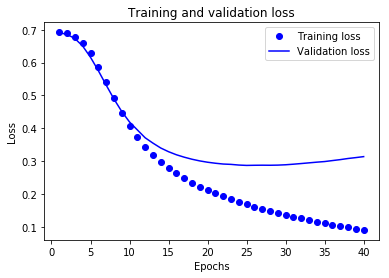

In [18]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

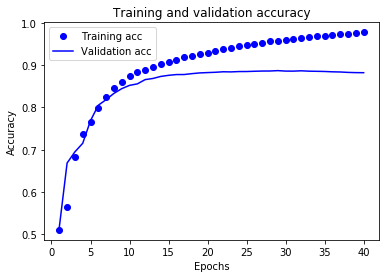

In [19]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()